# 
# <center>Estudio los datos de telecom con distintos algos de clasificación</center>

<a name="id8"></a>
**Índice**   
1. [KNN](#id1)
2. [Arbol de decisión](#id2)
3. [SVM](#id3)
4. [Regresión Logística](#id4)
5. [Random Forest](#id5)
6. [XGBoost](#id6)
7. [RESUMEN FINAL](#id7)

Carguemos las librerías necesarias

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools

### Acerca del set de datos

Imagina un proveedor de telecomunicaciones que ha segmentado la base de sus clientes por servicio, categorizando a los clientes en cuatro grupos. Si los datos demográficos se pueden usar para predecir la pertenencia de grupo del envío, la compañía podría personalizar las ofertas para los prospectos. Es un problema de clasificación. O sea, dado un set de datos, con etiquetas predefinidas, necesitaremos construir un modelo para predecir la clase de un nuevo o desconocido caso. 

Este ejemplo hace foco en datos demográficos, sean region, edad, estado civil, para predecir patrones de uso. 

El campo objetivo (target), llamado __custcat__, tiene cuatro valores posibles que corresponden a los cuatro grupos de clientes, a saber:
  1- Servicio Básico
  2- E-Servicio
  3- Servicio Plus
  4- Servicio Total

Nuestro objetivo es construir un clasificador para predecir la clase de casos desconocidos. Utilizaremos un tipo específico de clasificación llamado K vecino más cercano.


### Cargar Datos a partir de un archivo CSV (Valores Delimitados por Coma)  

In [3]:
df = pd.read_csv('~/Desktop/MLandPython/dataset archive/teleCust1000t.csv')

df.loc[df['custcat']==4,'custcat']=0
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,0
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


# Visualización de Datos y Análisis 



#### Veamos cuántos de cada clase están en nuestro set de datos 

In [4]:
df['custcat'].value_counts()

3    281
1    266
0    236
2    217
Name: custcat, dtype: int64

#### 281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers


Puedes explorar fácilmente tus datos utilizando técnicas de visualización:

array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

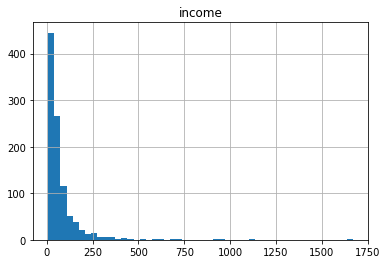

In [5]:
df.hist(column='income', bins=50)

### Feature set

Definamos feature sets, X:

In [6]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

Para utilizar la librería scikit-learn, tenemos que convertir el data frame de Panda en un Numpy array:

In [7]:
#vars_dep = ['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']

## Quito features para intentar bajar la varianza de SVM y mejora la prediccion (de todos)
#vars_dep = ['region','tenure', 'age', 'marital', 'address', 'income', 'ed', 'employ', 'retire','gender', 'reside']
vars_dep = ['region','tenure','marital','income', 'ed', 'retire','gender', 'reside']

X = df[vars_dep]
X[0:5]

,region,tenure,marital,income,ed,retire,gender,reside
0,2,13,1,64.0,4,0.0,0,2
1,3,11,1,136.0,5,0.0,0,6
2,3,68,1,116.0,1,0.0,1,2
3,2,33,0,33.0,2,0.0,1,1
4,2,23,1,30.0,1,0.0,0,4


¿Cuáles son nuestras etiquetas?

In [8]:
y_label = df.columns[-1]
y = df[y_label]
y[0:5]

0    1
1    0
2    3
3    1
4    3
Name: custcat, dtype: int64

## Normalizar los Datos 

La estandarización de Datos brinda a los datos cero media y varianza de unidad, es buena práctica, especialmente para algoritmos tales como KNN el cual se basa en distancia de casos:

In [9]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  1.0100505 , -0.12650641,  1.0877526 ,
        -0.22207644, -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563,  1.0100505 ,  0.54644972,  1.9062271 ,
        -0.22207644, -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  1.0100505 ,  0.35951747, -1.36767088,
        -0.22207644,  0.96655883, -0.23065004],
       [-0.02696767, -0.11831864, -0.9900495 , -0.41625141, -0.54919639,
        -0.22207644,  0.96655883, -0.92747794],
       [-0.02696767, -0.58672182,  1.0100505 , -0.44429125, -1.36767088,
        -0.22207644, -1.03459817,  1.16300577]])

### Train Test Split  
Al margen de la exactitud de la muestra, está el porcentaje de las predicciones correctas que el modelo hace de los datos para el que no ha sido entrenado. Al hacer un entrenamiento y prueba en el mismo set de datos, de seguro tendrán baja exactitud de muestra debido a la probabilidad de estar sobre dimensionado.

Es importante que nuestros modelos tengan una exactitud de muestra alta porque el propósito de cualquier modelos es lograr predicciones lo más certeras posibles sobre datos no conocidos. Entonces, ¿cómo podemos mejorar la precisión? Una forma es utilizar un enfoque de evaluación llamado Train/Test Split (Entrenar/Evaluar Dividir).
Esta forma requiere dividir el set de datos en conjuntos de entrenamiento y prueba, los cuales son mutuamente exclusivos. Luego de ello, se entrena con el conjunto de entrenamiento y se prueba con el conjunto de prueba.

Este método brinda una evaluación más precisa porque el set de prueba no es parte del conjunto de datos que ha sido utilizado para entrenar los datos. Es más realista para los problemas actuales.


In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=8)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)
(y_test==2).sum()

Set de Entrenamiento: (800, 8) (800,)
Set de Prueba: (200, 8) (200,)


46

# Clasificación 

<a name="id1"></a>
## K-vecinos más cercano (K-NN)

### Directamente optimizo hiperparámetros


Podemos calcular la certeza de KNN para diferentes Ks.

In [11]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Entrenar el Modelo y Predecir  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


#### Dibujo de la certeza del modelo para diferentes números de vecinos

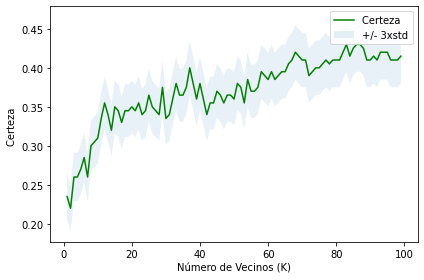

In [12]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vecinos (K)')
plt.tight_layout()
plt.show()

In [13]:
print( "La mejor aproximación de certeza fue con ", mean_acc.max(), "con k=", mean_acc.argmax()+1)


La mejor aproximación de certeza fue con  0.43 con k= 83


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [14]:
#Me quedo con el modelo mejor y lo entreno con X e Y train
knn_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1)
knn_model.fit(X_train,y_train)

#Hago predicción con X test y lo comparo con y test
ypred = knn_model.predict(X_train)
yhat = knn_model.predict(X_test)
  
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
knn_acc_train = accuracy_score(y_train, ypred)
knn_acc_test = accuracy_score(y_test, yhat)

print("Precisión de entrenamiento: ", knn_acc_train)
print("Precisión de test: ", knn_acc_test)
knn_model


Precisión de entrenamiento:  0.4325
Precisión de test:  0.43


KNeighborsClassifier(n_neighbors=83)

In [15]:
## Tenemos BIAS

<a name="id2"></a>
## Arbol de decisión

### Directamente optimizo hiperparámetros

In [16]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 3],
                 'max_depth'   : [3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    modelo = DecisionTreeClassifier(        
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    yhat2= modelo.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat2))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(7)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3} ✓


,accuracy,criterion,max_depth,max_features
4,0.370,gini,20,3
5,0.370,gini,20,3
10,0.335,entropy,20,3
11,0.335,entropy,20,3
2,0.330,gini,10,3
3,0.330,gini,10,3
0,0.310,gini,3,3


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [17]:
#Creo el modelo y lo entreno con X e Y train
dt_model = DecisionTreeClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
dt_model.fit(X_train,y_train)

#Hago predicción con Y test
ypred = dt_model.predict(X_train)
yhat2 = dt_model.predict(X_test)
  #yhat_prob = tree_model.predict_proba(X_test)
dt_acc_train = accuracy_score(y_train, ypred)
dt_acc_test = accuracy_score(y_test, yhat2)

print("Precisión de entrenamiento: ", dt_acc_train)
print("Precisión de test: ", dt_acc_test)
dt_model

Precisión de entrenamiento:  0.41
Precisión de test:  0.33


DecisionTreeClassifier(max_depth=3, max_features=3)

In [18]:
## Tenemos BIAS

In [19]:
print(confusion_matrix(y_test, yhat, labels=sorted(df['custcat'].unique())))
print (classification_report(y_test, yhat2))

[[14 10  3  4]
 [ 9 38  6 10]
 [13  6  7 20]
 [ 6 23  4 27]]
              precision    recall  f1-score   support

           0       0.29      0.45      0.35        31
           1       0.37      0.40      0.38        63
           2       0.00      0.00      0.00        46
           3       0.32      0.45      0.37        60

    accuracy                           0.33       200
   macro avg       0.25      0.32      0.28       200
weighted avg       0.26      0.33      0.29       200



/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [20]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,ed,0.719866
1,tenure,0.160929
2,marital,0.060885
3,income,0.036141
7,reside,0.022179
0,region,0.000000
5,retire,0.000000
6,gender,0.000000


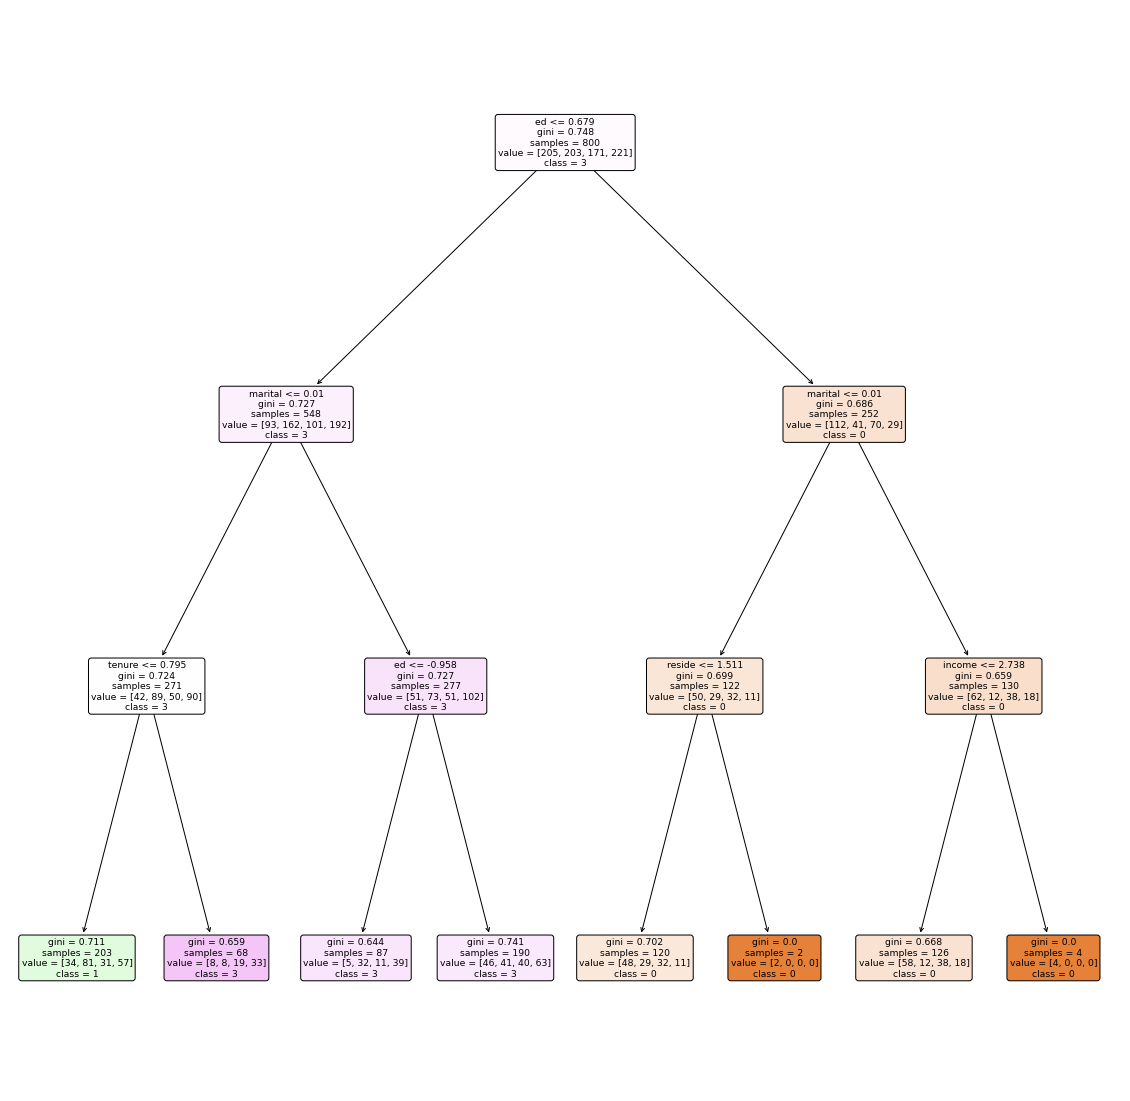

In [21]:
#Preparo las etiquetas del arbol
featureNames = vars_dep
targetNames = sorted(df["custcat"].unique().astype('str'))

#Esto Genera bien el fichero .dot
# arbol_dot = tree.export_graphviz(drugTree, out_file='drugtree.dot',
#                                  feature_names=featureNames, class_names=targetNames ,
#                                  filled=True, special_characters=True)  

#np.unique(y_trainset)
#Esto pinta bien el arbol, hay que poner antes el tamaño de la figura, sino lo hace muy pequeño
plt.figure(figsize=(20, 20))
plot_tree(dt_model, feature_names=featureNames, class_names=targetNames, filled=True, rounded=True,)
plt.show()

<a name="id3"></a>
## SVM Support Vector Machines

### Directamente optimizo hiperparámetros

In [22]:
# Itero con los 4 posibles kernel de SVM para ver cual es el mejor
kernel_params=['linear','poly','rbf','sigmoid']
acc_svm = pd.DataFrame(index=kernel_params)

for i in kernel_params:
    svm_model = svm.SVC(kernel=i)
    svm_model.fit(X_train, y_train)
    y_hat3 = svm_model.predict(X_test)
    acc_svm.at[i,'accuracy'] = accuracy_score(y_test, y_hat3)

# Extraigo el mejor
mejor_kernel = acc_svm[acc_svm['accuracy']==acc_svm['accuracy'].max()].index
mejor_kernel = np.array(mejor_kernel).astype('str')
print('El mejor kernel es ', mejor_kernel[0],'con una precisión de: ',acc_svm['accuracy'].max())
acc_svm

El mejor kernel es  poly con una precisión de:  0.39


,accuracy
linear,0.37
poly,0.39
rbf,0.33
sigmoid,0.32


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [23]:
# Construyo el modelo final con ese Kernel
svm_model = svm.SVC(kernel=mejor_kernel[0])
svm_model.fit(X_train,y_train)


#Hago predicción con X train y test
ypred = svm_model.predict(X_train)
yhat3 = svm_model.predict(X_test)

svm_acc_train = accuracy_score(y_train, ypred)
svm_acc_test = accuracy_score(y_test, yhat3)

print("Precisión de entrenamiento: ", svm_acc_train)
print("Precisión de test: ", svm_acc_test)

svm_model

Precisión de entrenamiento:  0.505
Precisión de test:  0.39


SVC(kernel='poly')

In [24]:
print(confusion_matrix(y_test, yhat3, labels=sorted(df['custcat'].unique())))
print (classification_report(y_test, yhat3))

[[14 10  2  5]
 [10 33  5 15]
 [15  7  7 17]
 [ 9 19  8 24]]
              precision    recall  f1-score   support

           0       0.29      0.45      0.35        31
           1       0.48      0.52      0.50        63
           2       0.32      0.15      0.21        46
           3       0.39      0.40      0.40        60

    accuracy                           0.39       200
   macro avg       0.37      0.38      0.36       200
weighted avg       0.39      0.39      0.38       200



<a name="id4"></a>
## Regresion Logística

### Directamente optimizo hiperparámetros

In [25]:
# Itero con los 5 posibles Solver de Reg Logística para ver cual es el mejor
solver_params=['lbfgs','liblinear','sag','saga','newton-cg']
acc_lr = pd.DataFrame(index=solver_params)

for i in solver_params:
    lr_model = LogisticRegression(C=0.01, solver=i)
    lr_model.fit(X_train, y_train)
    y_hat4 = lr_model.predict(X_test)
    acc_lr.at[i,'accuracy'] = accuracy_score(y_test, y_hat4)

# Extraigo el mejor
mejor_solver = acc_lr[acc_lr['accuracy']==acc_lr['accuracy'].max()].index
mejor_solver = np.array(mejor_solver).astype('str')
print('El mejor kernel es ', mejor_solver[0],'con una precisión de: ',acc_lr['accuracy'].max())
acc_lr  


El mejor kernel es  lbfgs con una precisión de:  0.395


,accuracy
lbfgs,0.395
liblinear,0.395
sag,0.395
saga,0.395
newton-cg,0.395


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [26]:
# Construyo el modelo final con ese Solver
lr_model = LogisticRegression(C=0.01,solver=mejor_solver[0])
lr_model.fit(X_train, y_train)

#Hago predicción con X train y test
ypred = lr_model.predict(X_train)
yhat4 = lr_model.predict(X_test)

lr_acc_train = accuracy_score(y_train, ypred)
lr_acc_test = accuracy_score(y_test, yhat4)

print("Precisión de entrenamiento: ", lr_acc_train)
print("Precisión de test: ", lr_acc_test)

lr_model

Precisión de entrenamiento:  0.4425
Precisión de test:  0.395


LogisticRegression(C=0.01)

In [27]:
print(confusion_matrix(y_test, yhat4, labels=sorted(df['custcat'].unique())))
print (classification_report(y_test, yhat4))

[[14 10  2  5]
 [14 35  2 12]
 [14  8  3 21]
 [ 9 19  5 27]]
              precision    recall  f1-score   support

           0       0.27      0.45      0.34        31
           1       0.49      0.56      0.52        63
           2       0.25      0.07      0.10        46
           3       0.42      0.45      0.43        60

    accuracy                           0.40       200
   macro avg       0.36      0.38      0.35       200
weighted avg       0.38      0.40      0.37       200



<a name="id5"></a>
## Random Forest

### Directamente optimizo hiperparámetros

In [28]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 5, 5],
                 'max_depth'   : [3, 10,20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                n_estimators= 100,        
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_d

,oob_accuracy,criterion,max_depth,max_features
0,0.39750,entropy,3,3
1,0.39500,gini,3,3
2,0.38875,gini,3,5
3,0.38875,gini,3,5


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [29]:
#Creo el modelo y lo entreno con X e Y train
rf_model = RandomForestClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
#rf_model = DecisionTreeClassifier(criterion="gini", max_depth = 10, max_features = 5,n_estimators= 100,random_state = 123)
rf_model.fit(X_train,y_train)

#Hago predicción con X train y test
ypred = rf_model.predict(X_train)
yhat5 = rf_model.predict(X_test)

rf_acc_train = accuracy_score(y_train, ypred)
rf_acc_test = accuracy_score(y_test, yhat5)

print("Precisión de entrenamiento: ", rf_acc_train)
print("Precisión de test: ", rf_acc_test)

rf_model

Precisión de entrenamiento:  0.4575
Precisión de test:  0.38


RandomForestClassifier(criterion='entropy', max_depth=3, max_features=3)

In [30]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': rf_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,ed,0.412349
1,tenure,0.334914
3,income,0.151292
7,reside,0.041656
2,marital,0.019144
5,retire,0.018874
0,region,0.016474
6,gender,0.005296


In [31]:
print(confusion_matrix(y_test, yhat5, labels=sorted(df['custcat'].unique())))
print (classification_report(y_test, yhat5))

[[12 11  0  8]
 [11 33  0 19]
 [10 10  2 24]
 [ 9 21  1 29]]
              precision    recall  f1-score   support

           0       0.29      0.39      0.33        31
           1       0.44      0.52      0.48        63
           2       0.67      0.04      0.08        46
           3       0.36      0.48      0.41        60

    accuracy                           0.38       200
   macro avg       0.44      0.36      0.33       200
weighted avg       0.44      0.38      0.34       200



<a name="id6"></a>
## XGBoost

### Directamente optimizo hiperparámetros

In [32]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100, 500, 1000],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth'   : [3, 5, 7],
                 'gamma' : [0.1, 0.2]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    xgb_model = XGBClassifier(
                use_label_encoder=False,
                verbosity=0,
                ** params
             )
    
    xgb_model.fit(X_train, y_train)
    yhat6= xgb_model.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat6))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(7)

Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 

,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.365,0.1,0.01,3.0,100.0
1,0.365,0.1,0.01,3.0,500.0
2,0.365,0.2,0.05,3.0,100.0
3,0.365,0.2,0.01,3.0,500.0
4,0.365,0.2,0.01,3.0,100.0
5,0.355,0.1,0.05,3.0,100.0
6,0.355,0.2,0.10,5.0,1000.0


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [33]:
#Creo el modelo y lo entreno con X e Y train
xgb_model = XGBClassifier(use_label_encoder=False,
                          n_estimators = resultados.at[0,'n_estimators'].astype('int'),
                          learning_rate = resultados.at[0,'learning_rate'],
                          max_depth = resultados.at[0,'max_depth'].astype('int'),
                          gamma = resultados.at[0,'gamma'])

xgb_model.fit(X_train, y_train)

ypred = xgb_model.predict(X_train)
yhat6 = xgb_model.predict(X_test)


xgb_acc_train = accuracy_score(y_train, ypred)
xgb_acc_test = accuracy_score(y_test, yhat6)

print("Precisión del Arbol de entrenamiento: ", xgb_acc_train)
print("Precisión del Arbol de test: ", xgb_acc_test)
xgb_model

Precisión del Arbol de entrenamiento:  0.48875
Precisión del Arbol de test:  0.365


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [34]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': xgb_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,ed,0.293703
1,tenure,0.235974
0,region,0.104209
3,income,0.101652
5,retire,0.092008
7,reside,0.085295
2,marital,0.062896
6,gender,0.024264


In [35]:
print(confusion_matrix(y_test, yhat6, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat6))

[[10 11  2  8]
 [11 30  2 20]
 [12  8  7 19]
 [ 9 20  5 26]]
              precision    recall  f1-score   support

           0       0.24      0.32      0.27        31
           1       0.43      0.48      0.45        63
           2       0.44      0.15      0.23        46
           3       0.36      0.43      0.39        60

    accuracy                           0.36       200
   macro avg       0.37      0.35      0.34       200
weighted avg       0.38      0.36      0.35       200



<a name="id7"></a>
## RESUMEN FINAL

Este es el resumen de resultados con cada algoritmo

In [36]:
Resultado_total = pd.DataFrame(
            {'Algoritmo':('KNN','Decision Tree','SVM','Logistic Regression','Random Forest','XGBoost'),
             'Precisión Entrenam':(knn_acc_train, dt_acc_train, svm_acc_train, lr_acc_train, rf_acc_train, xgb_acc_train),
             'Precisión Test':(knn_acc_test, dt_acc_test, svm_acc_test, lr_acc_test, rf_acc_test, xgb_acc_test),             
            })
Resultado_total.sort_values('Precisión Test', ascending=False)

,Algoritmo,Precisión Entrenam,Precisión Test
0,KNN,0.43250,0.430
3,Logistic Regression,0.44250,0.395
2,SVM,0.50500,0.390
4,Random Forest,0.45750,0.380
5,XGBoost,0.48875,0.365
1,Decision Tree,0.41000,0.330


[Retorno al principio](#id8)